#### Loading packages

In [179]:
import pandas as pd
import numpy as np

# ----------------------------------------------------------
# - SEASONAL DECOMPOSE

from statsmodels.tsa.seasonal import seasonal_decompose

# ----------------------------------------------------------
# - ACF and PACF

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller


# ----------------------------------------------------------
# - DATA VISUALIZATION

import matplotlib.pyplot as plt 
import plotly.graph_objs as go

# ----------------------------------------------------------
# - CONFIGURATIONS

import warnings
warnings.filterwarnings("ignore")

#### Loading Data

In [180]:
data = pd.read_excel("Microsoft_Stock_Data.xlsx")
data.tail()

,Date,Average Monthly Close
123,2024-04-30,413.263636
124,2024-05-31,417.537728
125,2024-06-30,438.342107
126,2024-07-31,445.339089
127,2024-08-31,412.530906


#### Data Checks

In [181]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   128 non-null    datetime64[ns]
 1   Average Monthly Close  128 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.1 KB


In [182]:
data.duplicated().sum()

np.int64(0)

In [183]:
data.isnull().sum()

Date                     0
Average Monthly Close    0
dtype: int64

#### Seasonal Decomposition of data

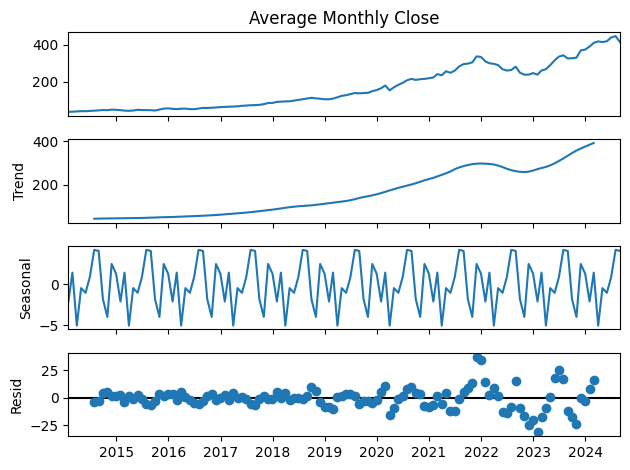

In [184]:
a = data.set_index("Date")
decompose_result = seasonal_decompose(a["Average Monthly Close"])
decompose_result.plot();

#### Plotting Residuals and Outliers 

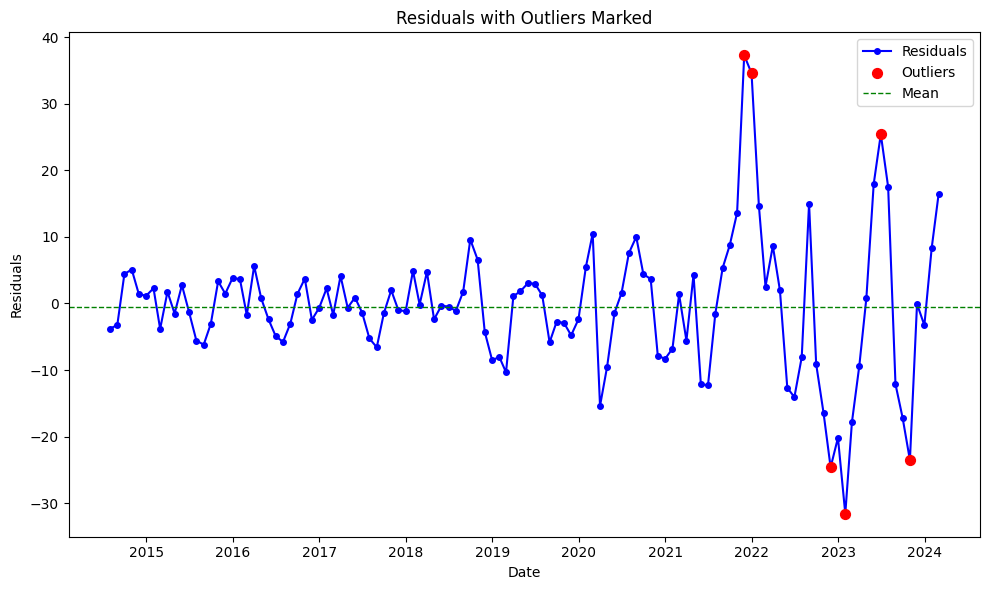

In [185]:
# Extract the residuals
residuals = decompose_result.resid

# Identify outliers: here, we use 2 standard deviations from the mean as the threshold
threshold = 2
mean_resid = np.mean(residuals)
std_resid = np.std(residuals)

# Mark outliers (where residuals are greater than the threshold)
outliers = residuals[(residuals > mean_resid + threshold * std_resid) | 
                     (residuals < mean_resid - threshold * std_resid)]

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals.index, residuals, label='Residuals', color='blue', marker='o', linestyle='-', markersize=4)

# Mark the outliers in red
plt.scatter(outliers.index, outliers, color='red', label='Outliers', zorder=3, s=50)

# Add labels and title
plt.title('Residuals with Outliers Marked')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.axhline(y=mean_resid, color='green', linestyle='--', linewidth=1, label='Mean')

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

#### ACF and PACF plots - before making data stationary

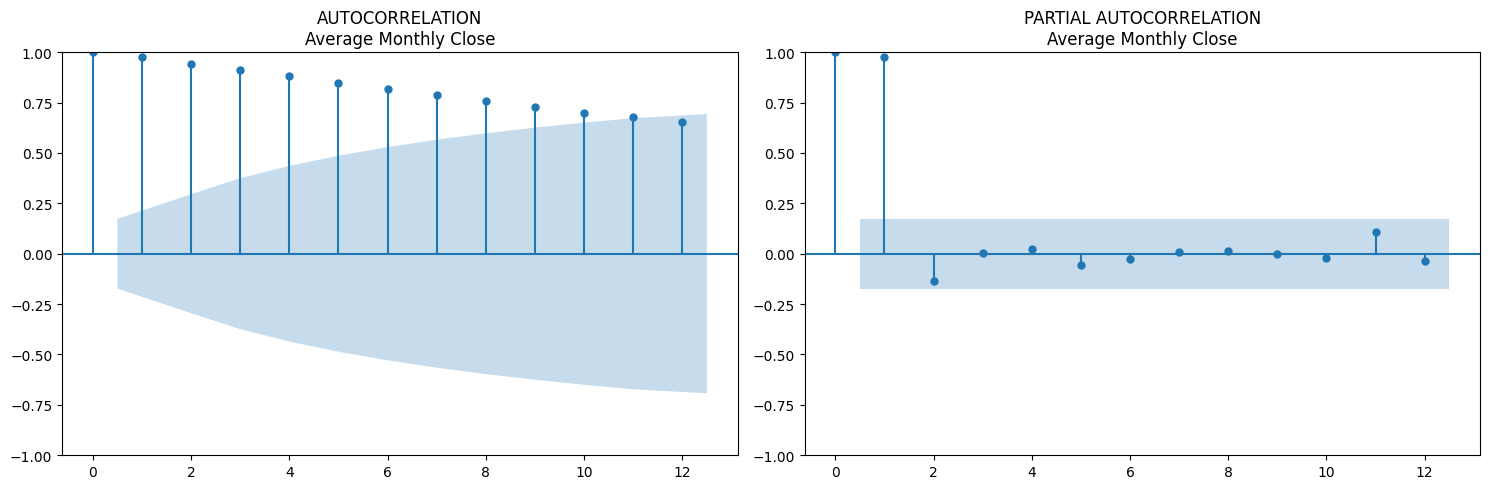

In [186]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sm.graphics.tsa.plot_acf(data["Average Monthly Close"], lags=12, ax=ax[0], title="AUTOCORRELATION\n"+ "Average Monthly Close")
sm.graphics.tsa.plot_pacf(data["Average Monthly Close"], lags=12, ax=ax[1], title="PARTIAL AUTOCORRELATION\n"+ "Average Monthly Close")
plt.tight_layout()
plt.plot();

* From ACF plot : average monthly close is highly correlated with price one month ago.
* From PACF plot : we can see the strength of positive correlation between lag 1 and monthly average prices.

#### ADF test for checking for stationarity

In [187]:
# Checking Stationarity of Data with ADF test
a = data.set_index("Date")
time_series = a["Average Monthly Close"]

# Run the Augmented Dickey-Fuller test
adf_result = adfuller(time_series)

# Extract and print results
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')


ADF Statistic: 1.1132464240682978
p-value: 0.9953281048125404
Critical Values:
	1%: -3.482920063655088
	5%: -2.884580323367261
	10%: -2.5790575441750883


* High p-value indicates the probability is high for the data to fall under the null hypothesis i.e the data is non-stationary. (p-value > 0.05)
* Test-Statistic is greater than all critical values, which re-confirms that the data is non-stationary.


In [188]:
# Differencing data to make data stationary

diff_data = data.copy(deep=True)

# First differencing of the 'Average Monthly Close' column
diff_data['First Differenced Close'] = diff_data['Average Monthly Close'].diff()

# Drop the first NaN value created due to differencing
#data.dropna(inplace=True)

# Display the first few rows
diff_data.head()

,Date,Average Monthly Close,First Differenced Close
0,2014-01-31,36.350476,NaN
1,2014-02-28,37.241579,0.891103
2,2014-03-31,38.985238,1.743660
3,2014-04-30,40.134285,1.149047
4,2014-05-31,39.920000,-0.214286


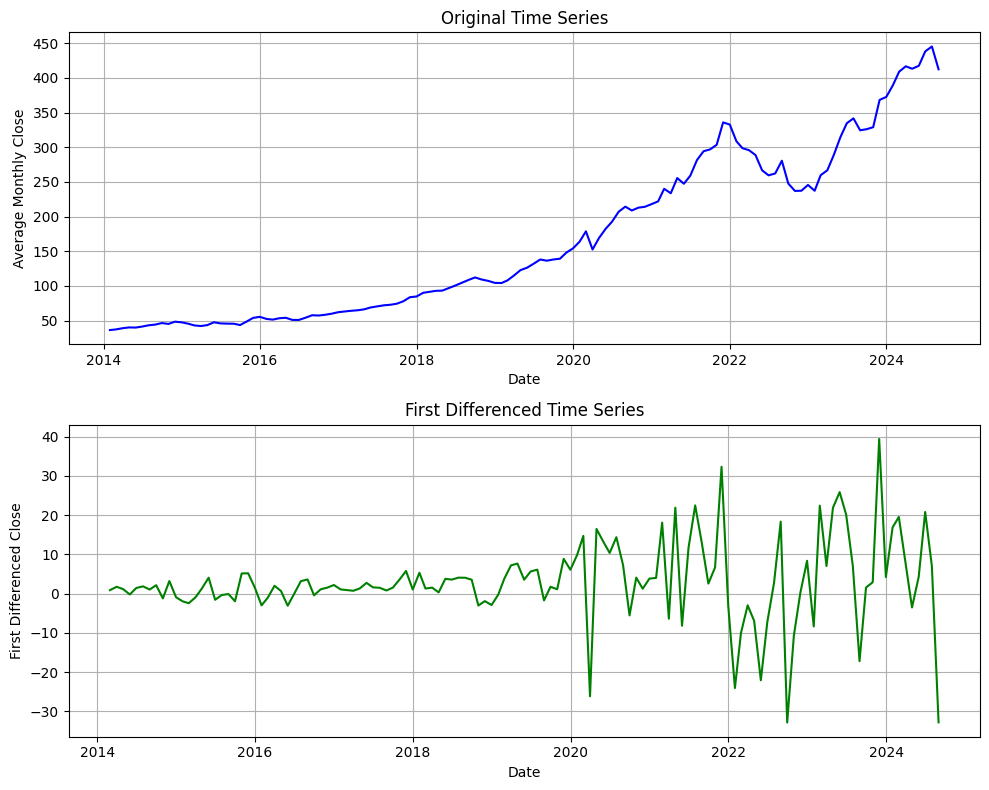

In [189]:
fig, ax = plt.subplots(2,1, figsize=(10,8))

ax[0].plot(diff_data["Date"],diff_data["Average Monthly Close"],color="blue")
ax[0].set_title("Original Time Series")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Average Monthly Close")
ax[0].grid(True)


ax[1].plot(diff_data["Date"],diff_data["First Differenced Close"],color="green")
ax[1].set_title("First Differenced Time Series")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("First Differenced Close")
ax[1].grid(True)

plt.tight_layout()
plt.show();

In [190]:
# Recheck stationarity using ADF test
a = diff_data[ (diff_data["First Differenced Close"].notna()) ]
a = a.set_index("Date")
time_series = a["First Differenced Close"]

# Run the Augmented Dickey-Fuller test
adf_result = adfuller(time_series)

# Extract and print results
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')


ADF Statistic: -9.152969652546075
p-value: 2.6558211657015056e-15
Critical Values:
	1%: -3.4833462346078936
	5%: -2.8847655969877666
	10%: -2.5791564575459813


* The data is stationary according to the above results (p-value < 0.05 AND test statistic < all critical values).

#### ACF plots - after making data stationary

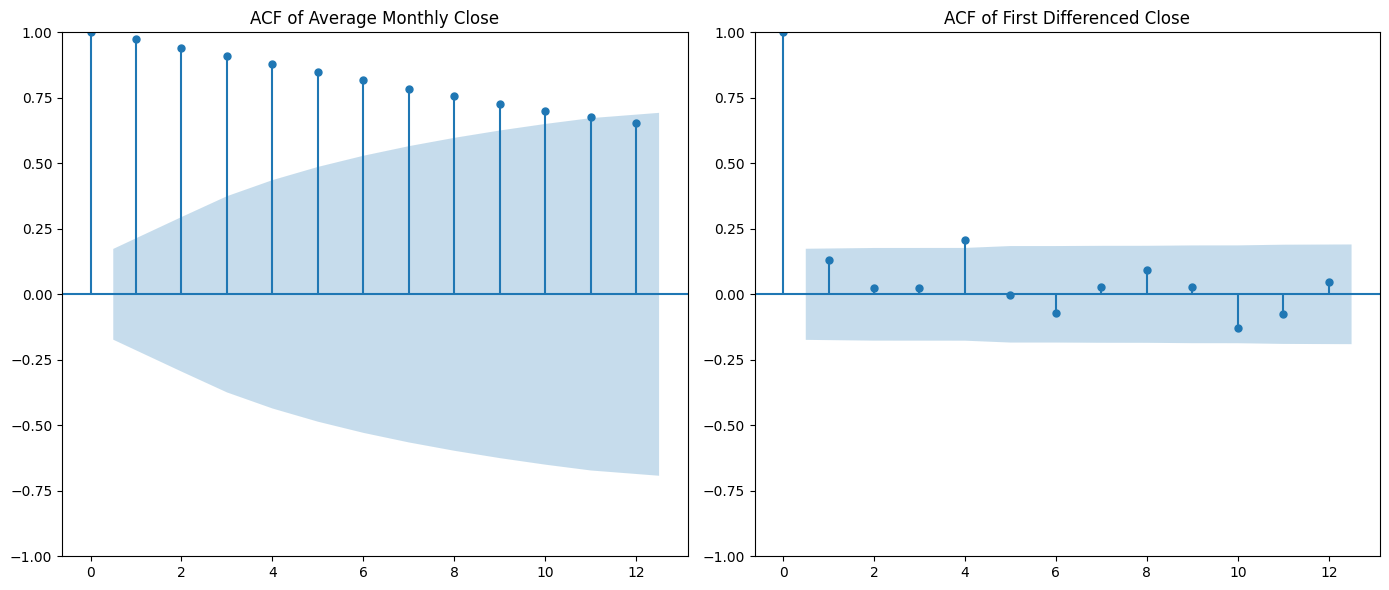

In [191]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create a figure and plot ACF side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# ACF plot for original "Average Monthly Close" data
plot_acf(diff_data['Average Monthly Close'], lags=12, ax=axes[0])
axes[0].set_title('ACF of Average Monthly Close')

# ACF plot for first-differenced data
a = diff_data[ (diff_data["First Differenced Close"].notna()) ]
plot_acf(a['First Differenced Close'], lags=12, ax=axes[1])
axes[1].set_title('ACF of First Differenced Close')

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the plots
plt.show()

Trick to see if data is stationary after differencing : Right side acf plot shows quick decay to no correlation with time, indicating there are no long term dependancies with time, whereas left side shows greater correlation with previous time lag.

#### Extra: Log Differrencing data

In [192]:
diff_data.head()

,Date,Average Monthly Close,First Differenced Close
0,2014-01-31,36.350476,NaN
1,2014-02-28,37.241579,0.891103
2,2014-03-31,38.985238,1.743660
3,2014-04-30,40.134285,1.149047
4,2014-05-31,39.920000,-0.214286


In [193]:
# Applying log transformation followed by first differencing to make data stationary

a = diff_data.copy(deep=True)

# Apply logarithm transformation to 'Average Monthly Close'
a['Log Average Close'] = np.log(a['Average Monthly Close'])

# Apply first differencing to the log-transformed values
diff_data['Log Differenced Close'] = a['Log Average Close'].diff()

In [194]:
diff_data.head()

,Date,Average Monthly Close,First Differenced Close,Log Differenced Close
0,2014-01-31,36.350476,NaN,NaN
1,2014-02-28,37.241579,0.891103,0.024219
2,2014-03-31,38.985238,1.743660,0.045757
3,2014-04-30,40.134285,1.149047,0.029048
4,2014-05-31,39.920000,-0.214286,-0.005354


In [195]:
a = diff_data[ (diff_data["Log Differenced Close"].notna()) ] 
a.head()

,Date,Average Monthly Close,First Differenced Close,Log Differenced Close
1,2014-02-28,37.241579,0.891103,0.024219
2,2014-03-31,38.985238,1.743660,0.045757
3,2014-04-30,40.134285,1.149047,0.029048
4,2014-05-31,39.920000,-0.214286,-0.005354
5,2014-06-30,41.361905,1.441905,0.035483


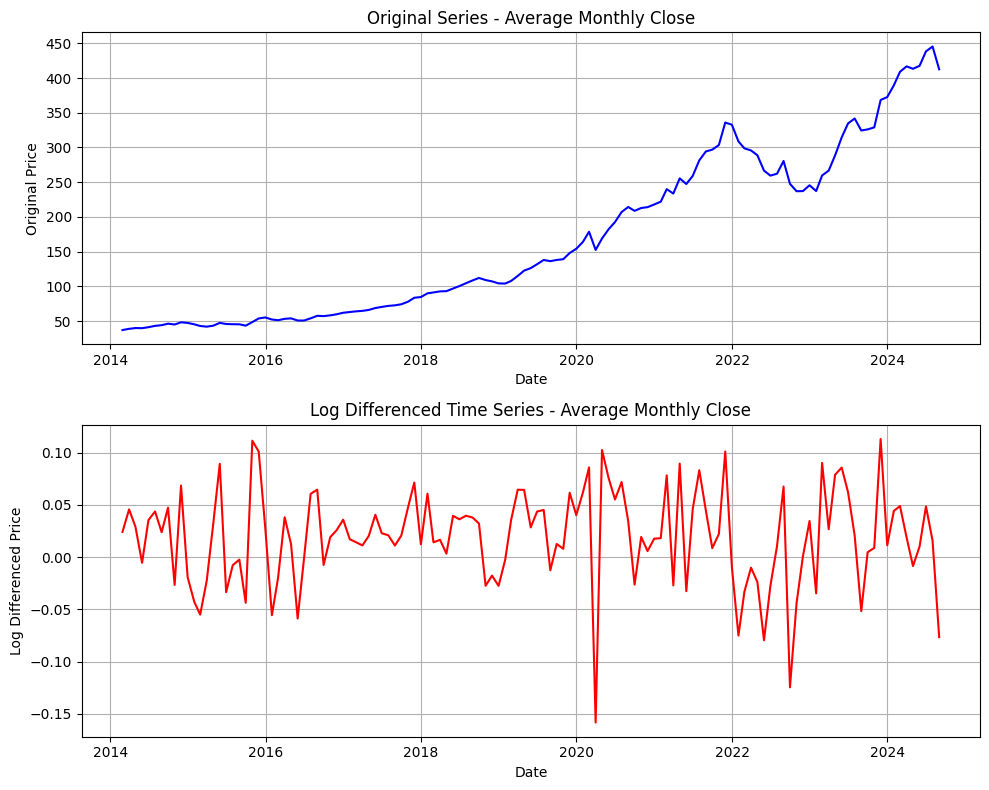

In [196]:
# Plot both the log-differenced data and original data
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot log-transformed time series
a = diff_data[ (diff_data["Log Differenced Close"].notna()) ] 

axes[0].plot(a.Date, a['Average Monthly Close'], color='blue')
axes[0].set_title('Original Series - Average Monthly Close')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Original Price')
axes[0].grid(True)

# Plot first differenced log-transformed time series
axes[1].plot(a.Date, a['Log Differenced Close'], color='red')
axes[1].set_title('Log Differenced Time Series - Average Monthly Close')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Log Differenced Price')
axes[1].grid(True)

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show();

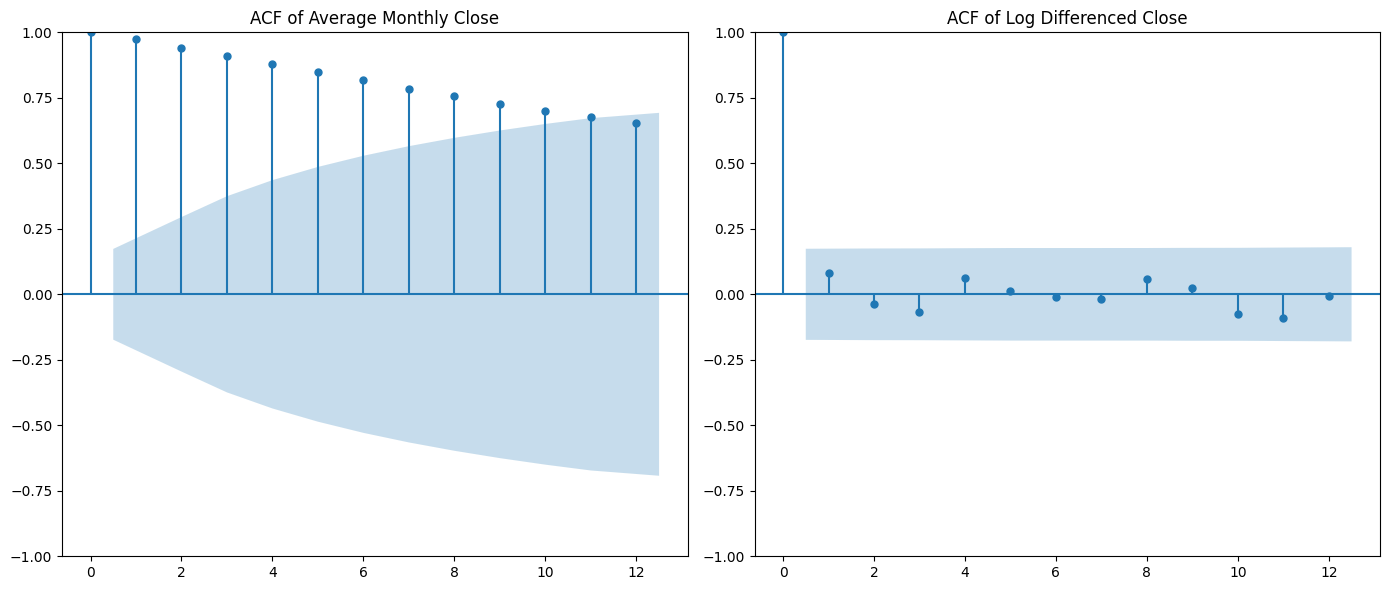

In [197]:
# Create a figure and plot ACF side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# ACF plot for original "Average Monthly Close" data
plot_acf(diff_data['Average Monthly Close'], lags=12, ax=axes[0])
axes[0].set_title('ACF of Average Monthly Close')

# ACF plot for first-differenced data
a = diff_data[ (diff_data["Log Differenced Close"].notna()) ]
plot_acf(a['Log Differenced Close'], lags=12, ax=axes[1])
axes[1].set_title('ACF of Log Differenced Close')

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the plots
plt.show()

#### ARIMA with differenced data

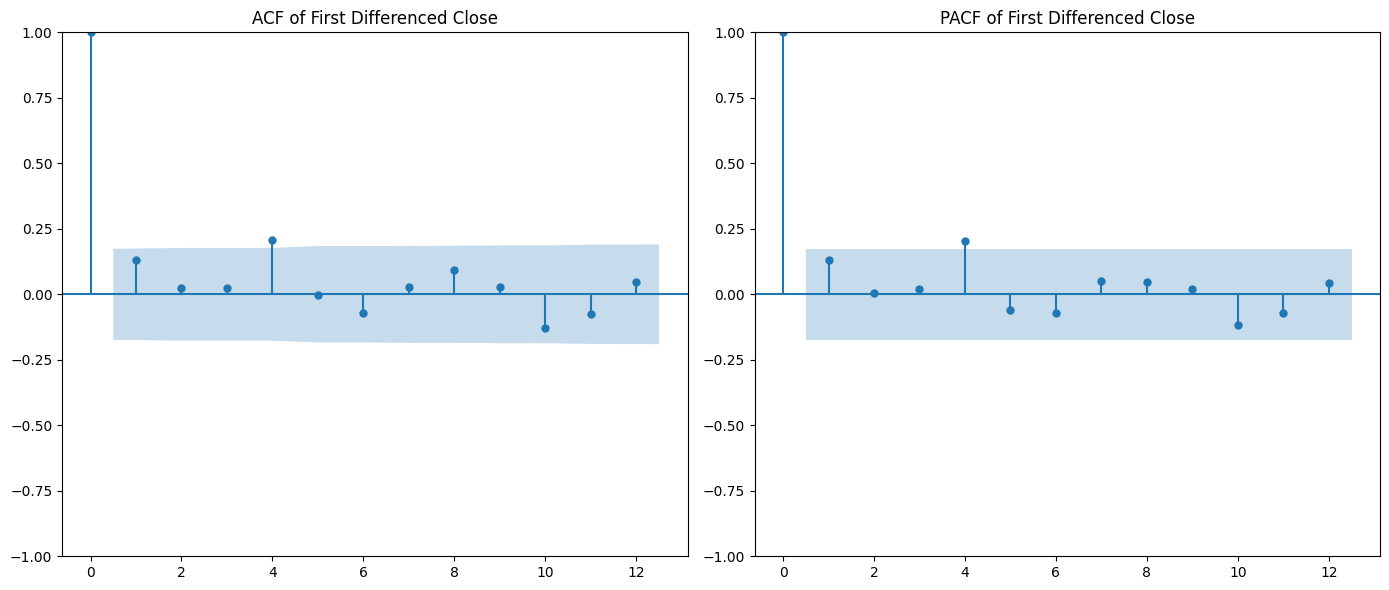

In [198]:
# Hyperparameter tuning for ARIMA by observing ACF and PACF plots on first differenced data
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create a figure and plot ACF side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

a = diff_data[ (diff_data["First Differenced Close"].notna()) ]

# ACF plot for original "Average Monthly Close" data
plot_acf(a['First Differenced Close'], lags=12, ax=axes[0])
axes[0].set_title('ACF of First Differenced Close')

# ACF plot for first-differenced data

plot_pacf(a['First Differenced Close'], lags=12, ax=axes[1])
axes[1].set_title('PACF of First Differenced Close')

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the plots
plt.show();

Since the ACF plot shows significant drop in value after lag 0 , choosing q = 0 as a hyperparameter is a practical choice, p value from pacf based on same reasoning is 0 as well.

In [199]:
# Splitting data into train and test
a = data.copy(deep=True)

# Ensure 'Date' is in datetime format and set it as the index
a['Date'] = pd.to_datetime(a['Date'])
a.set_index('Date', inplace=True)

# Split data into training and testing sets
train_end = '2024-07-31'  # End of the training period
train = a.loc[:train_end].copy(deep=True)
test = a[-1:].copy(deep=True)

In [200]:
# ARIMA model
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Apply ARIMA (p=1, d=1, q=1) to the training data
model = ARIMA(train['Average Monthly Close'], order=(0, 1, 0))
model_fit = model.fit()

# Forecast on the test set
forecast = model_fit.forecast()[0]

last_actual_value = train['Average Monthly Close'].iloc[-1]  # Last known value from the training data

# Add forecasted values to the test set
test['Predicted Average Monthly Close'] = forecast

# Calculate and print mean squared error (MSE) as an example metric
mse = mean_squared_error(test['Average Monthly Close'], test['Predicted Average Monthly Close'])
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1076.3768815946187


In [201]:
# Print the forecast for August 2024
print(f"Predicted average closing price for August 2024: {test['Predicted Average Monthly Close']}")

Predicted average closing price for August 2024: Date
2024-08-31    445.339089
Name: Predicted Average Monthly Close, dtype: float64


#### ARIMA with log differenced data

In [202]:
# Apply logarithm transformation to 'Average Monthly Close'
diff_data['Log Average Close'] = np.log(diff_data['Average Monthly Close'])

In [203]:
# Applying log transformation followed by first differencing to make data stationary
a = diff_data.copy(deep=True)

# Apply first differencing to the log-transformed values
diff_data['Log Differenced Close'] = a['Log Average Close'].diff()

In [204]:
diff_data.head()

,Date,Average Monthly Close,First Differenced Close,Log Differenced Close,Log Average Close
0,2014-01-31,36.350476,NaN,NaN,3.593207
1,2014-02-28,37.241579,0.891103,0.024219,3.617426
2,2014-03-31,38.985238,1.743660,0.045757,3.663183
3,2014-04-30,40.134285,1.149047,0.029048,3.692231
4,2014-05-31,39.920000,-0.214286,-0.005354,3.686877


In [205]:
# Splitting data into train and test
a = diff_data.copy(deep=True)
a.drop(["Average Monthly Close"],axis=1,inplace=True)

# Ensure 'Date' is in datetime format and set it as the index
a['Date'] = pd.to_datetime(a['Date'])
a.set_index('Date', inplace=True)

# Split data into training and testing sets
train_end = '2024-07-31'  # End of the training period
train = a.loc[:train_end].copy(deep=True)
test = a[-1:].copy(deep=True)

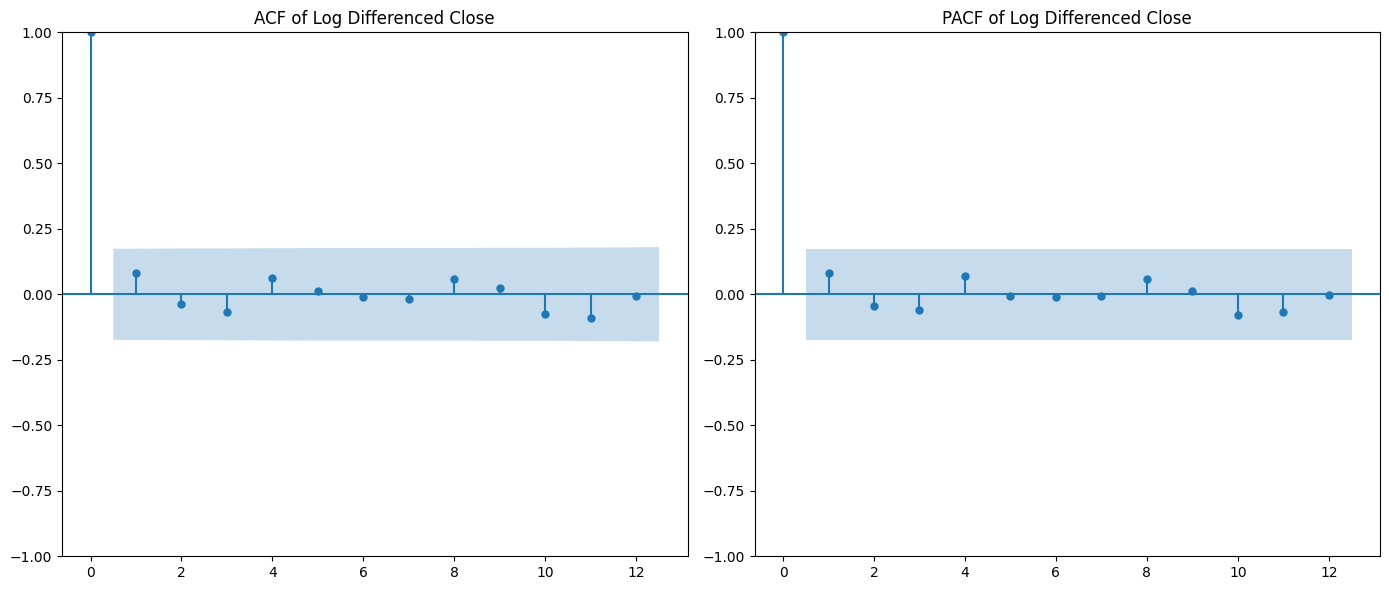

In [206]:
# Create a figure and plot ACF side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

a = diff_data[ (diff_data["Log Differenced Close"].notna()) ]

# ACF plot for original  Differenced Monthly Close" data
plot_acf(a["Log Differenced Close"], lags=12, ax=axes[0])
axes[0].set_title('ACF of Log Differenced Close')

# ACF plot for first-differenced data

plot_pacf(a["Log Differenced Close"], lags=12, ax=axes[1])
axes[1].set_title('PACF of Log Differenced Close')

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the plots
plt.show();

In [207]:
# Hyperparameter tuning for log transformed data

# Apply ARIMA (p=1, d=1, q=1) to the training data
model = ARIMA(train['Log Average Close'], order=(0, 1, 0))
model_fit = model.fit()

# Forecast on the test set
forecast = model_fit.forecast()[0]

last_actual_value = diff_data['Average Monthly Close'].iloc[-1]  # Last known value from the training data

# Add forecasted values to the test set
test['Predicted Log Average Close'] = forecast
test["Average Monthly Close"] = last_actual_value
test["Predicted Average Monthly Close"] = np.exp(forecast)


In [208]:
# Print the forecast for August 2024
print(f"Predicted average closing price for August 2024: {test['Predicted Average Monthly Close']}")

Predicted average closing price for August 2024: Date
2024-08-31    445.339089
Name: Predicted Average Monthly Close, dtype: float64


In [209]:
# Calculate and print mean squared error (MSE) as an example metric
mse = mean_squared_error(test['Average Monthly Close'], test['Predicted Average Monthly Close'])
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1076.3768815946223


#### Exponential Smoothing ETS

In [210]:
# Exponential Smoothing ETS model
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

# Assuming your time series data is in a DataFrame called `df`
# with the target column `Average Monthly Close`
data = diff_data['Average Monthly Close']

# Define the possible components for Error, Trend, and Seasonality
error_components = ['add', 'mul']  # Additive, Multiplicative
trend_components = ['None', 'add', 'add_d']  # No Trend, Additive, Additive Damped
seasonality_components = ['None', 'add', 'mul']  # No Seasonality, Additive, Multiplicative

# To store results
results = []

# Loop through all combinations of Error, Trend, and Seasonality
for error in error_components:
    for trend in trend_components:
        for seasonality in seasonality_components:
              
            # Fit the ETS model for each variant
            try:
                model = ETSModel(data, 
                                 error=error, 
                                 trend= trend.replace('_d', ''), 
                                 damped_trend= (trend == 'add_d'), 
                                 seasonal=seasonality if seasonality != 'N' else None,
                                 seasonal_periods=12 )

                model_fit = model.fit()

                # Get the AIC value
                aic_value = model_fit.aic

                # Save the results in a list
                results.append({
                    'Error': error,
                    'Trend': trend,
                    'Seasonality': seasonality,
                    'AIC': aic_value
                })
                print(f"Model: {error} {trend} {seasonality} | AIC: {aic_value}")

            except Exception as e:
                # Handle exceptions (e.g., non-convergence) gracefully
                print(f"Model: {error} {trend} {seasonality} failed: {e}")

# Convert the results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Sort by AIC to find the best model
results_df = results_df.sort_values(by='AIC')

print("Best ETS model based on AIC:")
print(results_df.head())

Model: add None None failed: If not None, trend must be one of: 'add', 'mul', 'additive', 'multiplicative'
Model: add None add failed: If not None, trend must be one of: 'add', 'mul', 'additive', 'multiplicative'
Model: add None mul failed: If not None, trend must be one of: 'add', 'mul', 'additive', 'multiplicative'
Model: add add None failed: If not None, seasonal must be one of: 'add', 'mul', 'additive', 'multiplicative'
Model: add add add | AIC: 980.3944204941316
Model: add add mul | AIC: 961.3213533716464
Model: add add_d None failed: If not None, seasonal must be one of: 'add', 'mul', 'additive', 'multiplicative'
Model: add add_d add | AIC: 980.5439551893103
Model: add add_d mul | AIC: 956.4185146336155
Model: mul None None failed: If not None, trend must be one of: 'add', 'mul', 'additive', 'multiplicative'
Model: mul None add failed: If not None, trend must be one of: 'add', 'mul', 'additive', 'multiplicative'
Model: mul None mul failed: If not None, trend must be one of: 'add'

In [211]:
train = diff_data.drop(["Log Average Close","Log Differenced Close"],axis=1)[:-1]
test =  diff_data.drop(["Log Average Close","Log Differenced Close"],axis=1)[-1:]

In [212]:
train.set_index("Date",inplace=True)
train.tail()

,Average Monthly Close,First Differenced Close
Date,,
2024-03-31,416.789500,7.795502
2024-04-30,413.263636,-3.525865
2024-05-31,417.537728,4.274092
2024-06-30,438.342107,20.804379
2024-07-31,445.339089,6.996982


In [213]:
# Fit the ETS model with multiplicative error (M), additive trend (A), and multiplicative seasonality (M)
# Assume seasonality is monthly, so seasonal_periods=12
model = ETSModel(train["Average Monthly Close"],      
                 error="mul", 
                 trend= "add", 
                 seasonal="mul",
                 seasonal_periods=12 )

# Forecast the values for August 2024

fit = model.fit()
forecast = fit.forecast(len(test))

# The last forecasted value will correspond to the prediction for August 2024
august_2024_forecast = forecast

# Print the forecast for August 2024
print(f"Predicted average closing price for August 2024: {august_2024_forecast}")

Predicted average closing price for August 2024: 2024-08-31    452.416027
Freq: ME, dtype: float64


In [214]:
test["Predicted Average Monthly Close"] = august_2024_forecast[0]
# Calculate and print mean squared error (MSE) as an example metric
mse = mean_squared_error(test['Average Monthly Close'], test['Predicted Average Monthly Close'])
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1590.8229033266966


#### Conclusion

* Taking simplicity of model building and best accuracy / lowest error - the model I have chosen the ARIMA model with first differenced data, which gave me lower MSE compared to Exponential Smoothing ETS, and was simpler to implement in comparison to ARIMA with Log differenced data - which was of comparable MSE.

    1. MSE of ARIMA (first differenced data): 1076.376881594619 (**chosen model**)
    2. MSE of ARIMA (log differenced data)  : 1076.376881594622
    3. MSE of Exponential Smoothing ETS     : 1590

* Predicted average price of stock for month August = 452
* Actual average price of stock for month August    = 412

The model is not perfect, but it was able to predict a pretty close value of the stock.